Remakes SED files with updated Lya and errors on all models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.io import readsav


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [2]:
stars =['GJ1132',
 'GJ15A',
 'GJ163',
 'GJ649',
 'GJ674',
 'GJ676A',
 'GJ699',
 'GJ729',
 'GJ849',
 'L-980-5',
 'LHS-2686',
 'TRAPPIST-1']



Lya. Technique -rather than try to update prepare model here, use the g430L (as they all have it) as the basis and go from there.

In [4]:
hlsp_path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/'
path = '../new_lya/'
lyas = glob.glob('{}*results.csv'.format(path))
lyas

['../new_lya/GJ649_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ674_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ15A_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ729_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ849_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ1132_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/LHS2686_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ676A_LyA_only_CowanSR_MCMC_results.csv',
 '../new_lya/GJ163_LyA_only_CowanSR_MCMC_results.csv']

In [31]:
import prepare_model

In [33]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

In [46]:

for star in stars:
    print(star)
    if star == 'TRAPPIST-1':
        data = Table.read('../new_lya/TRAPPIST1_MCMC_results.txt', format='csv')
        w, f = data['wave_mm'], data['LyA_intrinsic_profile_median_mm']
        e = np.mean([(data['LyA_intrinsic_profile_high_1sig_mm']-f),(f-data['LyA_intrinsic_profile_low_1sig_mm'])], axis=0)
        
        
        
    elif star == 'GJ699':
        data = Table.read('../new_lya/GJ699_G140M_final_fits.txt', format='csv')
        w, f = data['wave'], data['best_fit_intrinsic']
        e = np.mean([(data['intrinsic_high_1sig']-f),(f-data['intrinsic_low_1sig'])], axis=0)
        
    elif star=='L-980-5':
        data = Table.read('../new_lya/L980-5_lya_basic.txt', format='csv')
        w, f = data['WAVELENGTH'], data['FLUX']
        data = Table.read('../new_lya/GJ699_G140M_final_fits.txt', format='csv')
        modup = np.median((data['intrinsic_high_1sig']-data['best_fit_intrinsic'])/data['best_fit_intrinsic']) #need for L980-5
        moddn = np.median((abs(data['intrinsic_low_1sig']-data['best_fit_intrinsic']))/data['best_fit_intrinsic']) #need for L980-5
        e = np.mean([f*modup, f*moddn], axis=0) 

    else:
        data = Table.read('{}{}_LyA_only_CowanSR_MCMC_results.csv'.format(path, star.replace('-', '')))
        w, f = data['wave_lya'], data['lya_intrinsic_median']
        e = np.mean([(data['lya_intrinsic_high_1sig']-f),(f-data['lya_intrinsic_low_1sig'])], axis=0)
        
    
    g430l = glob.glob('{}{}/*g430l*'.format(hlsp_path, star))[0]
    hdr = fits.getheader(g430l, 0)
    
    w0, w1 = wavelength_edges(w)
    
    model_data = Table([w*u.AA,w0*u.AA, w1*u.AA, f*u.erg/u.s/u.cm**2/u.AA, e*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'WAVELENGTH0', 'WAVELENGTH1', 'FLUX', 'ERROR'])
    savepath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/{}/'.format(star)

    normfac = 1.0
    metadata = prepare_model.make_model_metadata(model_data,  normfac, hdr, 'LYA-RECONSTRUCTION')
    version =24
    prepare_model.model_save_to_fits(model_data, metadata, savepath, version)
    
    
        
#     plt.plot(w, f)
#     plt.plot(w, e)
#     plt.show()

    

GJ1132
Spectrum saved as hlsp_muscles_model_lya-reconstruction_gj1132_na_v24_component-spec.fits
GJ15A
Spectrum saved as hlsp_muscles_model_lya-reconstruction_gj15a_na_v24_component-spec.fits
GJ163
Spectrum saved as hlsp_muscles_model_lya-reconstruction_gj163_na_v24_component-spec.fits
GJ649
Spectrum saved as hlsp_muscles_model_lya-reconstruction_gj649_na_v24_component-spec.fits
GJ674
Spectrum saved as hlsp_muscles_model_lya-reconstruction_gj674_na_v24_component-spec.fits
GJ676A
Spectrum saved as hlsp_muscles_model_lya-reconstruction_gj676a_na_v24_component-spec.fits
GJ699
Spectrum saved as hlsp_muscles_model_lya-reconstruction_gj699_na_v24_component-spec.fits
GJ729
Spectrum saved as hlsp_muscles_model_lya-reconstruction_gj729_na_v24_component-spec.fits
GJ849
Spectrum saved as hlsp_muscles_model_lya-reconstruction_gj849_na_v24_component-spec.fits
L-980-5
Spectrum saved as hlsp_muscles_model_lya-reconstruction_l-980-5_na_v24_component-spec.fits
LHS-2686
Spectrum saved as hlsp_muscles_mo

PHX - build on optical_model_uncertanties in optical dir 

In [5]:
params = Table.read('../optical/stellar_parameters.csv')

In [29]:
# import prepare_phoenix_svo as pp


In [41]:
# G = const.G
# M = const.M_sun.to(u.kg)
# R = const.R_sun.to(u.m)
# repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'
# for row in params:
#     star = row['Target']
#     star = star.replace(' ', '')
#     print(star)
#     mass = row['Mass']
#     teff = row['Teff']
#     teff_e = row['Teff_e']
#     radius = row['Radius']
#     distance = row['distance']
#     savepath = 'new_phx_intermediates/'
#     g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
#     star_params = {'Teff': teff, 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc, 'Teff_e':teff_e}
#     pw, pf, pe = pp.make_phoenix_spectrum(star, savepath, repo, star_params, save_ecsv=True, plot=False, make_error=True)
#     normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2
    
#     plt.plot(pw, pf)
#     plt.plot(pw, pe)
#     plt.yscale('log')
#     plt.xscale('log')
#     plt.show()
    







# # star_params = {'Teff': teff, 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc, 'Teff_e':teff_e}
# # pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=False, make_error=True)
# # 


In [45]:
for star in stars:
    phx = Table.read('new_phx_intermediates/{}_phoenix_interpolated.ecsv'.format(star))
    
    g430l = glob.glob('{}{}/*g430l*'.format(hlsp_path, star))[0]
    hdr = fits.getheader(g430l, 0)

    w0, w1 = wavelength_edges(phx['WAVELENGTH'])
    
    model_data = Table([phx['WAVELENGTH']*u.AA, w0*u.AA, w1*u.AA, phx['FLUX']*u.erg/u.s/u.cm**2/u.AA,  phx['ERROR']*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'WAVELENGTH0', 'WAVELENGTH1', 'FLUX', 'ERROR'])
    savepath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/{}/'.format(star)
    normfac = phx.meta['NORMFAC'].value
    metadata = prepare_model.make_model_metadata(model_data,  normfac, hdr, 'PHX')
    # savepath = 'new_phx_hlsp/'
    version =24
    prepare_model.model_save_to_fits(model_data, metadata, savepath, version)

Spectrum saved as hlsp_muscles_model_phx_gj1132_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_gj15a_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_gj163_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_gj649_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_gj674_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_gj676a_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_gj699_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_gj729_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_gj849_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_l-980-5_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_lhs-2686_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_2mass-j23062928-0502285_na_v24_component-spec.fits


APEC, already did some work for this... waiting to see if Alex has a table.

Linsky scalings - Lya errors? They have systematic uncertainties as well. Could ignore. Make table of Lya flux and error, will need it for paper anyway

In [17]:
import importlib
import linsky_euv

Spectrum saved as hlsp_muscles_model_euv-scaling_gj1132_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_gj15a_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_gj163_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_gj649_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_gj674_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_gj676a_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_gj699_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_gj729_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_gj849_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_l-980-5_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_lhs-2686_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_euv-scaling_2mass-j23062928-0502285_na_v24_component-s

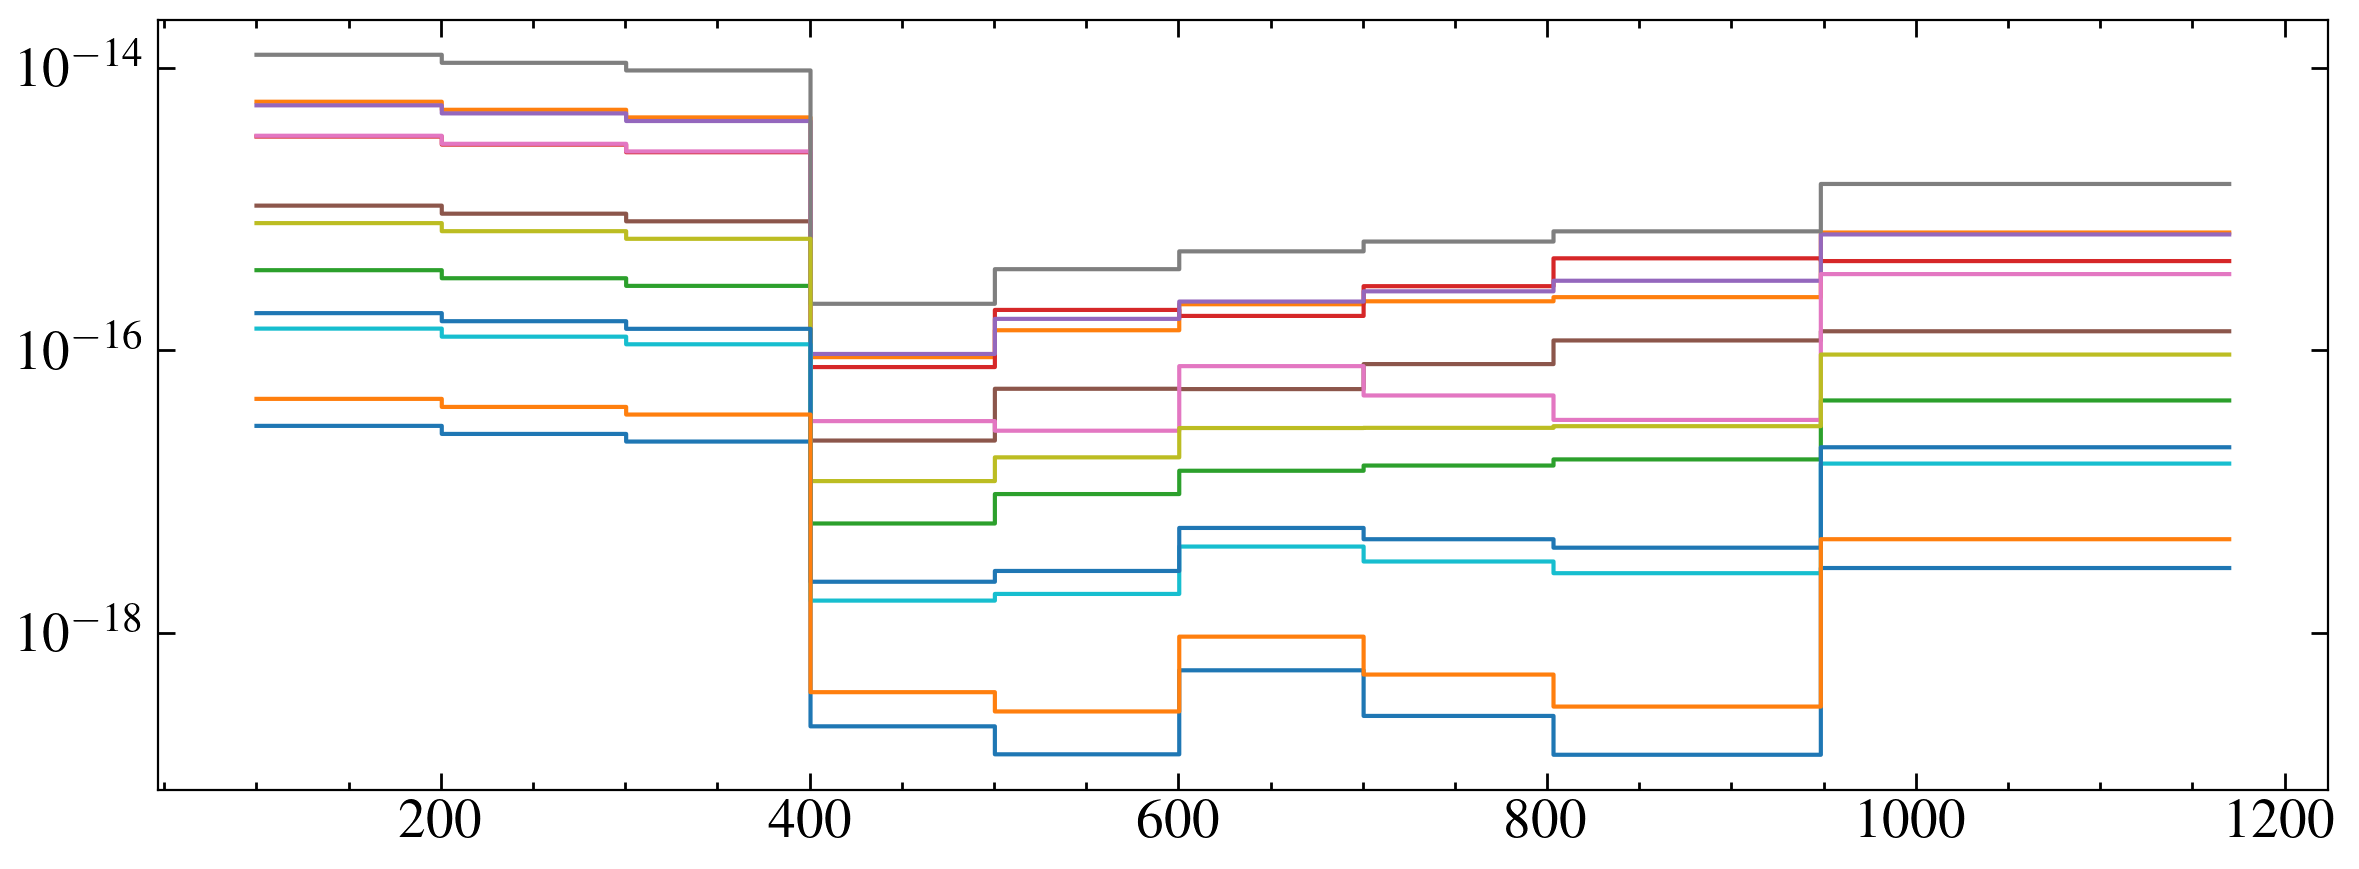

In [42]:
importlib.reload(linsky_euv)

# hlsp_path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/'
lya_f = []
lya_feu = []
lya_fel = []
lya_n = []
lya_neu = []
lya_nel = []
lya_p = []
lya_peu = []
lya_pel = []

        
distances = [12.03804021, 3.562014676, 15.01726986, 10.3755966, 4.540501271, 15.85539876,1.823785815,2.969826562,8.830022075,13.39405304,13.14060447,12.10946961]


for i, star in enumerate(stars):
    # print(star)
    if star == 'TRAPPIST-1':
        fi, feu, fel = 1.4e-14, 0.6e-14,0.36e-14
        ni, neu, nel = 18.4, 0.1, 0.1
        pi, peu, pel = 0.0, 0.0, 0.0
        
    elif star == 'GJ699':
        data = Table.read('../new_lya/GJ699_G140M_final_fits.txt', format='csv')
        fi, feu, fel = 1.02e-12, 0.02e-12, 0.02e-12
        ni, neu, nel = 17.6, 0.02, 0.02
        pi, peu, pel = 0.0, 0.0, 0.0
       
    elif star=='L-980-5':
        data = Table.read('../new_lya/L980-5_lya_basic.txt', format='csv')
        fi, feu, fel = 4.4e-14, 0.9e-14, 0.9e-14
        ni, neu, nel = 0.0, 0.0, 0.0
        pi, peu, pel = 0.0, 0.0, 0.0 
        # w, f = data['WAVELENGTH'], data['FLUX']
        # data = Table.read('../new_lya/GJ699_G140M_final_fits.txt', format='csv')
        # modup = np.median((data['intrinsic_high_1sig']-data['best_fit_intrinsic'])/data['best_fit_intrinsic']) #need for L980-5
        # moddn = np.median((abs(data['intrinsic_low_1sig']-data['best_fit_intrinsic']))/data['best_fit_intrinsic']) #need for L980-5
        # e = np.mean([f*modup, f*moddn], axis=0) 

    else:
        data = Table.read('{}{}_LyA_only_CowanSR_MCMC_results.csv'.format(path, star.replace('-', '')))
        f, n, p = data['lya_intrinsic_fluxes'], data['h1_col value'], data['p value']
        fi, feu, fel = f[2], f[3]-f[2], f[2]-f[1]
        ni, neu, nel = n[2], n[3]-n[2], n[2]-n[1]
        pi, peu, pel = p[2], p[3]-p[2], p[2]-p[1]
    lya_f.append(fi)
    lya_feu.append(feu)
    lya_fel.append(fel)
    lya_n.append(ni)
    lya_neu.append(neu)
    lya_nel.append(nel)
    lya_p.append(pi)
    lya_peu.append(peu)
    lya_pel.append(pel)
    
    w_euv, f_euv = linsky_euv.euv_estimator(fi, distances[i], star=star)
    w_euv, eu_euv = linsky_euv.euv_estimator(fi+feu, distances[i], star=star)
    w_euv, el_euv = linsky_euv.euv_estimator(fi-fel, distances[i], star=star)
    
    e_euv = np.mean([f_euv-el_euv, eu_euv-f_euv], axis=0)
    
    plt.step(w_euv, f_euv, where='mid')
    # mask = np.isnan(f_euv)==True
    # plt.scatter(w_euv[mask], w_euv[mask])
    # plt.axvline(100)
    # plt.axvline(1170)
    
    
    # plt.step(w_euv, e_euv, where='mid')
    plt.yscale('log')
    
    # plt.show()
    g430l = glob.glob('{}{}/*g430l*'.format(hlsp_path, star))[0]
    hdr = fits.getheader(g430l, 0)

    w0, w1 = wavelength_edges(w_euv)
    
    model_data = Table([w_euv*u.AA,w0*u.AA, w1*u.AA, f_euv*u.erg/u.s/u.cm**2/u.AA,  e_euv*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'WAVELENGTH0', 'WAVELENGTH1', 'FLUX', 'ERROR'])
    savepath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/{}/'.format(star)

    normfac = 1.0
    metadata = prepare_model.make_model_metadata(model_data,  normfac, hdr, 'euv-scaling')
    # savepath = 'new_euv_hlsp/'
    version =24
    prepare_model.model_save_to_fits(model_data, metadata, savepath, version)
    
        


    

In [22]:
for i, star in enumerate(stars):
    name = '{0} & '.format(star)
    flux ='${0:.2g}^{{+{1:.2g}}}_{{-{2:.2g}}}$ & '.format(lya_f[i]*1e14, lya_feu[i]*1e14,lya_fel[i]*1e14)
    ism = '${0:.3g}^{{+{1:.2g}}}_{{-{2:.2g}}}$ & '.format(lya_n[i], lya_neu[i],lya_nel[i])
    sr = '${0:.3g}^{{+{1:.2g}}}_{{-{2:.2g}}}$ \\\ '.format(lya_p[i], lya_peu[i],lya_pel[i])
    
    print(name + flux + ism +sr)
    


GJ1132 & $0.9^{+0.56}_{-0.23}$ & $17.5^{+0.62}_{-0.88}$ & $1.34^{+0.3}_{-0.24}$ \\ 


IndexError: list index out of range

In [23]:
for row in params:
    print(row['Target'], row['distance'])

GJ 1132 12.03804021
GJ 676A 15.85539876
GJ 15A 3.562014676
GJ 649 10.3755966
GJ 163 15.01726986
GJ 849 8.830022075
GJ 674 4.540501271
GJ 699 1.823785815
L 980-5 13.39405304
LHS 2686 13.14060447
GJ 729 2.969826562
Trappist-1 12.10946961


In [24]:
stars

['GJ1132',
 'GJ15A',
 'GJ163',
 'GJ649',
 'GJ674',
 'GJ676A',
 'GJ699',
 'GJ729',
 'GJ849',
 'L-980-5',
 'LHS-2686',
 'TRAPPIST-1']

In [36]:
#estimate errors for l 980-5 using upper limit on count rate
rate = 0.86*6.9
sqrt = rate**0.5
eper = sqrt/rate
fx = 0.81
e = fx*eper
print(rate, sqrt, eper, e)

5.934 2.4359802954868086 0.4105123517840931 0.33251500494511543


In [7]:
new_apecs = glob.glob('../xray/new_apec_specs/*apec*')
new_apecs

['../xray/new_apec_specs/GJ676A_apec_errs.ecsv',
 '../xray/new_apec_specs/GJ649_apec_errs.ecsv',
 '../xray/new_apec_specs/GJ163_apec_errs.ecsv',
 '../xray/new_apec_specs/GJ699_apec_errs.ecsv',
 '../xray/new_apec_specs/TRAPPIST-1_apec_errs.ecsv',
 '../xray/new_apec_specs/GJ729_apec_errs.ecsv',
 '../xray/new_apec_specs/GJ15A_apec_errs.ecsv',
 '../xray/new_apec_specs/GJ1132_apec_errs.ecsv',
 '../xray/new_apec_specs/GJ674_apec_errs.ecsv',
 '../xray/new_apec_specs/GJ849_apec_errs.ecsv',
 '../xray/new_apec_specs/L-980-5_apec_errs.ecsv',
 '../xray/new_apec_specs/LHS-2686_apec_errs.ecsv']

In [41]:
for star in stars:
    g430l = glob.glob('{}{}/*g430l*'.format(hlsp_path, star))[0]
    hdr = fits.getheader(g430l, 0)
    
    apec = glob.glob('../xray/new_apec_specs/*{}_apec*'.format(star))
    model_data = Table.read(apec[0])
    
    w0, w1 = wavelength_edges(model_data['WAVELENGTH'])
    
    model_data = Table([model_data['WAVELENGTH']*u.AA,w0*u.AA, w1*u.AA, model_data['FLUX']*u.erg/u.s/u.cm**2/u.AA, model_data['ERROR']*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'WAVELENGTH0', 'WAVELENGTH1', 'FLUX', 'ERROR'])
    savepath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/{}/'.format(star)


    normfac = 1.0
    metadata = prepare_model.make_model_metadata(model_data,  normfac, hdr, 'apec')
    # savepath = 'new_apec_hlsp/'
    version =24
    prepare_model.model_save_to_fits(model_data, metadata, savepath, version)

Spectrum saved as hlsp_muscles_model_apec_gj1132_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_gj15a_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_gj163_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_gj649_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_gj674_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_gj676a_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_gj699_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_gj729_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_gj849_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_l-980-5_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_lhs-2686_na_v24_component-spec.fits
Spectrum saved as hlsp_muscles_model_apec_2mass-j23062928-0502285_na_v24_component-spec.fits


Last but not least, DEMS. New ones later.

In [13]:
# dempaths = ['../trappist-1/dem/trappist-1_dem_table.dat', ]

In [80]:
17.72113803571706 - 17.750425098876025

-0.029287063158964344

oops forgot to add W0, W1 to the new models...

In [ ]:
new_hlsp_path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/'
for star in stars:
    